# Introduction

In [6]:
# begin by importing Arbor
import arbor as A
from arbor import units as U
# we will also get support to plot things
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utils import plot_morphology

# A Data-Driven Model from the Allen Brain Atlas

We are going to show how one particular model from the mouse brain catalogue of the Allen Institute's
electrophysiology database can be converted to Arbor. This is mainly a matter of converting the JSON
data in the database to an Arbor `decor`. Unfortunately, the data schema varies between experiments, so
this method is more of a blueprint of how to approach this kind of problem then a universal solution.

## Obtaining the Data

The Allen Cell DB provides electrophysiology experiments for download like in this link:
https://celltypes.brain-map.org/experiment/electrophysiology/488683425
In this part, we are going to use the data in the 'biophysical -- all active' model, which
is already included with this notebook.

In [7]:
import json
from collections import defaultdict
from dataclasses import dataclass
from typing import Optional

## Loading the Morphology, JSON, and Reference Data

The morphology comes as an SWC file, which we know how to handle. The parametrisation comes
in a JSON file, which we load using the Python standard library. Finally, the reference membrane
potential is included as a CSV containing pairs of $(t/ms, U/mV)$, for convenience, we use Pandas.

In [8]:
raw = A.load_swc_neuron('single_cell_allen.swc')
mrf = raw.morphology
lbl = raw.labels
lbl.add_swc_tags()
ref = pd.read_csv('single_cell_allen_neuron_ref.csv', usecols=[1,2], index_col=0)
with open('single_cell_allen_fit.json') as fd:
    fit = json.load(fd)
# values in the reference need to be adjusted
ref['U/mV'] *= 1000.0
ref['U/mV'] += fit["fitting"][0]["junction_potential"]

(<Figure size 1000x1000 with 1 Axes>,
 <Axes3D: xlabel='x $(\\mu m)$', ylabel='y $(\\mu m)$', zlabel='z $(\\mu m)$'>)

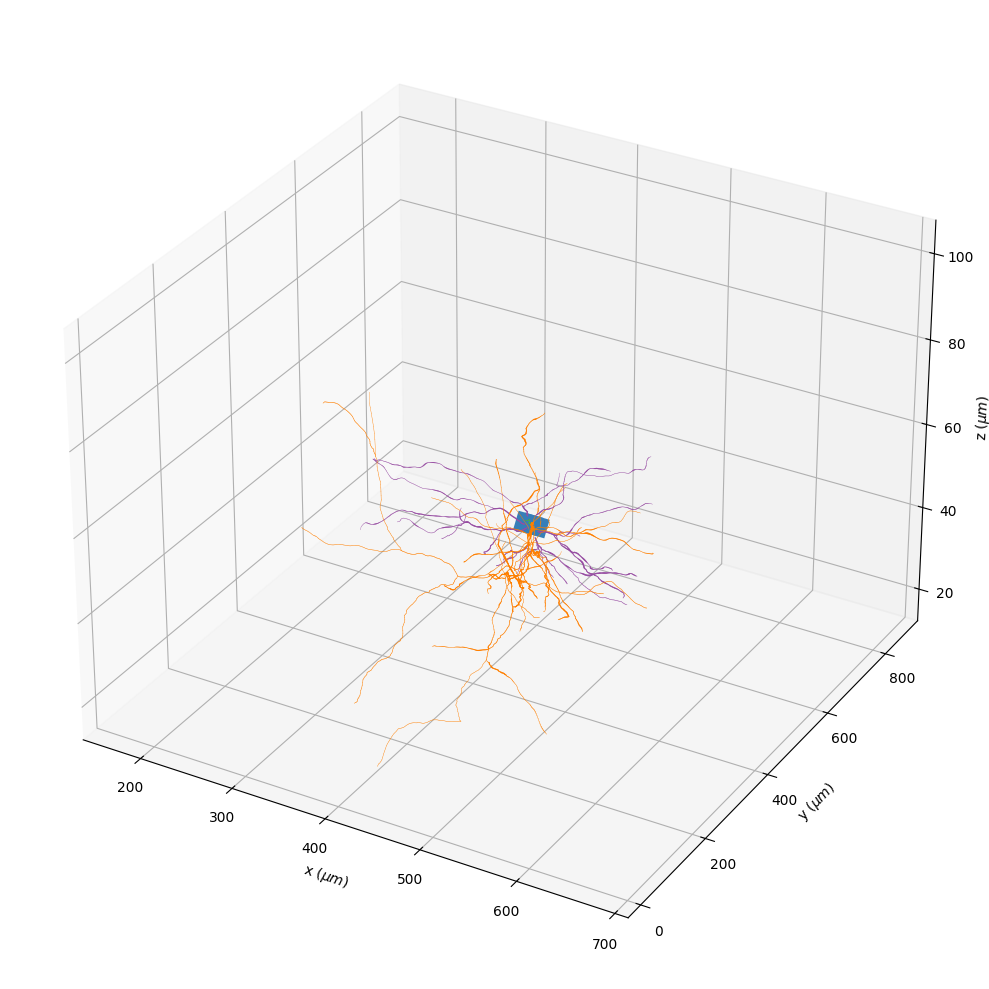

In [9]:
plot_morphology(raw)

## From `fit` to `decor`

The core task here is to construct a `decor` from the data contained in the JSON object.
We will not discuss the actual reverse engineering of the format (which is also neither
documented nor consistent between model), but rather showcase some functionality the 
simple example left out.

### Parameters

In the first example above, we didn't discuss how to handle physical parameters:
- temperature
- resistivity
- capacitance
- membrane voltage

These (and similar values for ion properties) are set using a three-level system
- global
- cell-wide
- per-region

where more specific values override generic ones. Here, with one cell, global and
cell defaults are equivalent.

In [10]:
# a convenient way to hold sets of parameters
@dataclass
class parameters:
    cm:   Optional[float] = None # uF/cm2
    temp: Optional[float] = None # K
    Vm:   Optional[float] = None # mV
    rL:   Optional[float] = None # Ohm cm

# get the default parameters from the JSON data (cm will be None, thus we will use the
# implicit default of Arbor.
default = parameters(temp=float(fit["conditions"][0]["celsius"]) * U.Celsius,
                     Vm=float(fit["conditions"][0]["v_init"]) * U.mV,
                     rL=float(fit["passive"][0]["ra"]) * U.Ohm * U.cm)

Now, we have obtained the global default set of parameters. Next, we will traverse the data
to pull out the per-region overrides. Unfortunately, that data is intermingled with the information
about ion channels. Thus, we build a second dictionary for this purpose in the same pass.

In [11]:
param = defaultdict(parameters)
mechs = defaultdict(dict)
for block in fit["genome"]:
    mech = block["mechanism"] or "pas"
    region = block["section"]
    name = block["name"]
    value = float(block["value"])
    if name.endswith("_" + mech):
        name = name.removesuffix("_" + mech)
    elif mech == "pas":
        # transform names and values
        if name == "cm":
            param[region].cm = value * U.uF / U.cm2
        elif name == "Ra":
            param[region].rL = value * U.Ohm * U.cm
        elif name == "Vm":
            param[region].Vm = value * U.mV
        elif name == "celsius":
            param[region].temp = value * U.Celsius
        else:
            raise Exception(f"Unknown key: {name}")
        continue
    else:
        raise Exception(f"Illegal combination {mech} {name}")
    mechs[(region, mech)][name] = value

This gives us a set of parameters per region and the information to attach ion channels to regions, incuding their parameter settings.
Let's add this to a `decor`

In [12]:
dec = A.decor()

# set the default
dec.set_property(
    tempK=default.temp,
    Vm=default.Vm,
    cm=default.cm,
    rL=default.rL,
)
# override regional parameters
for region, vs in param.items():
    dec.paint(
        f'"{region}"',
        tempK=vs.temp,
        Vm=vs.Vm,
        cm=vs.cm,
        rL=vs.rL,
    )

Now, add the ion channels. What's new here is that `paint`ing an ion channel includes setting the values declared `PARAMETER` in NMODL.
Ignore the manipulation of the mechanism names for now (or ask about it), it is a way of handling `GLOBAL` values.

In [13]:
for (region, mech), values in mechs.items():
    nm = mech
    vs = {}
    sp = "/"
    for k, v in values.items():
        if mech == "pas" and k == "e":
            nm = f"{nm}{sp}{k}={v}"
            sp = ","
        else:
            vs[k] = v
    print(region, nm, vs)
    dec.paint(f'"{region}"', A.density(A.mechanism(nm, vs)))

soma pas/e=-76.4024 {'g': 0.000119174}
axon pas/e=-64.8595 {'g': 0.00147346}
apic pas/e=-81.3599 {'g': 0.00041148}
dend pas/e=-88.2554 {'g': 9.57001e-05}
axon NaV {'gbar': 0.035766}
axon K_T {'gbar': 7.51307e-05}
axon Kd {'gbar': 0.00700751}
axon Kv2like {'gbar': 0.0675078}
axon Kv3_1 {'gbar': 0.592911}
axon SK {'gbar': 0.000701147}
axon Ca_HVA {'gbar': 2.17253e-06}
axon Ca_LVA {'gbar': 0.00698184}
axon CaDynamics {'gamma': 0.0416279, 'decay': 226.076}
soma NaV {'gbar': 0.0499779}
soma SK {'gbar': 0.000733676}
soma Kv3_1 {'gbar': 0.186718}
soma Ca_HVA {'gbar': 9.96973e-05}
soma Ca_LVA {'gbar': 0.00344495}
soma CaDynamics {'gamma': 0.0177038, 'decay': 42.2507}
soma Ih {'gbar': 1.07608e-07}
apic NaV {'gbar': 0.000375636}
apic Kv3_1 {'gbar': 0.797015}
apic Im_v2 {'gbar': 0.00854163}
apic Ih {'gbar': 7.40408e-07}
dend NaV {'gbar': 0.0472215}
dend Kv3_1 {'gbar': 0.186859}
dend Im_v2 {'gbar': 0.00132163}
dend Ih {'gbar': 9.18815e-06}


### Running the Model

At this point we can run the model, although it's still incomplete. Since we will do it more than once, we pack this into a function. We are using the recipe interface here to hightlight a few points.

In [14]:
def run_allen_model(cell, ref_um, tfinal=1400, dt=0.005):
    class recipe(A.recipe):

        def __init__(self, cell):
            A.recipe.__init__(self)
            self.the_cell = cell
            self.the_prop = A.neuron_cable_properties()
            # this is new; tell Arbor to load its internal collection
            # of ion channels relevant to the Allen models
            self.the_prop.catalogue.extend(A.allen_catalogue(),'')

        def num_cells(self):
            return 1

        def cell_kind(self, gid):
            return A.cell_kind.cable

        def cell_description(self, gid):
            # in the last tutorial, we created the `cable_cell` on the fly
            # every time `cell_description` was called. This is not required,
            # and if your model comprises copies of a single instance, you can
            # set that up once and just return the cached instance.
            # _However_ the inverse is also true: If you need to source random
            # data, make sure every call with the same `gid` creates the same
            # output!
            return self.the_cell

        def global_properties(self, kind):
            return self.the_prop

        def probes(self, gid):
            return [A.cable_probe_membrane_voltage('(location 0 0.5)', 'Um')]    
    rec = recipe(cell)
    sim = A.simulation(rec)
    hdl = sim.sample((0, 'Um'), A.regular_schedule(5*U.us))
    sim.run(tfinal=tfinal*U.ms, dt=dt*U.ms)
    fg, ax = plt.subplots()
    for data, meta in sim.samples(hdl):
        ax.plot(data[:, 0], data[:, 1], label=f"@{str(meta)}")
    ax.plot(ref_um.index.values, ref_um['U/mV'].values, label='Reference')
    ax.legend()
    ax.set_xlabel('Time $t/ms$')
    ax.set_ylabel('Potential $U_m/mV$')
    ax.set_xlim(0, tfinal)

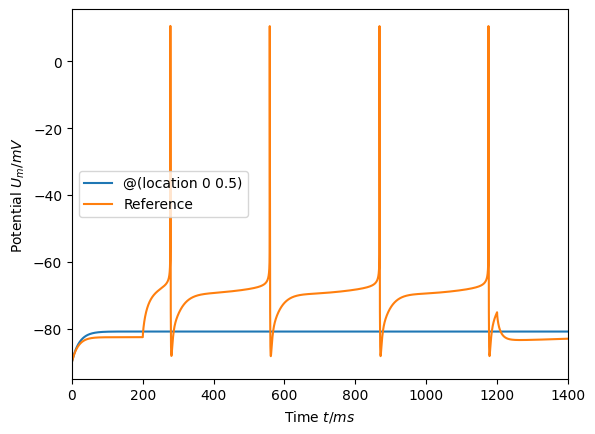

In [15]:
run_allen_model(A.cable_cell(mrf, dec, lbl), ref)

This should feel largely familiar by now, except the marked line. It is used to bring the ion channels from the Allen Database into scope, which come predefined with Arbor.

We also note that the result doesn't look like the reference, since a few details are missing. Most importantly, there is no stimulus so far. As the
data was obtained from the $150\,pA$ experiment, let's add a current clamp and re-run the model.

### Adding Stimulus

In [16]:
dec.place('(location 0 0.5)', A.iclamp(200*U.ms, 1000*U.ms, 150*U.pA), "ic")

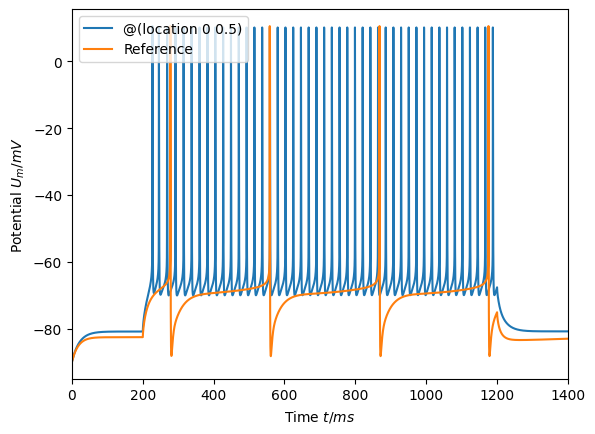

In [17]:
run_allen_model(A.cable_cell(mrf, dec, lbl), ref)

### Adjusting Ion Reversal Potentials

Now, we see some activity (more than expected, actually), but are still not on par with the reference.
The data contains the ion concentrations in some regions, thus we need to adjust accordingly.

In [18]:
erev = dict()
for kv in fit["conditions"][0]["erev"]:
    region = kv["section"]
    for k, v in kv.items():
        if k == "section":
            continue
        ion = k[1:]
        erev[(region, ion)] = float(v)*U.mV

In [19]:
for (region, ion), e in erev.items():
    dec.paint(f'"{region}"', ion=ion, rev_pot=e)

Again `paint` is used to set values on a region. Let's re-run

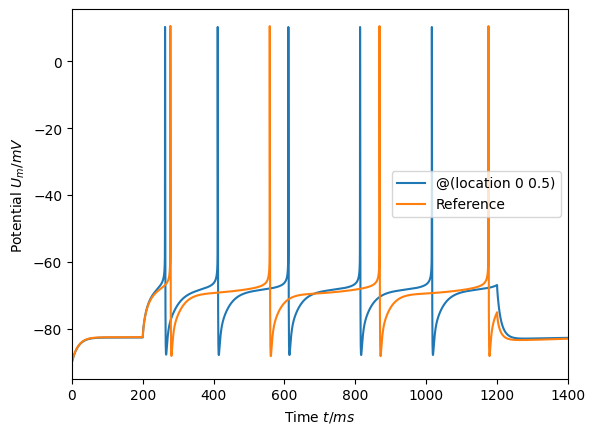

In [20]:
run_allen_model(A.cable_cell(mrf, dec, lbl), ref)

Better! However, NEURON has some intricacies when it comes to handling reversal potentials. 
Under certain conditions, the Nernst rule is used implicitly. In Arbor, we decided not to emulate
this behaviour to avoid confusion. Thus, we add this by hand:

In [21]:
dec.set_ion("ca", int_con=5e-5*U.mM, ext_con=2.0*U.mM, method="nernst/x=ca")

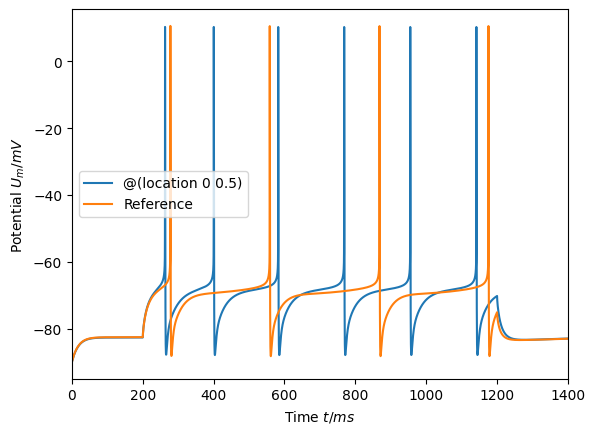

In [22]:
run_allen_model(A.cable_cell(mrf, dec, lbl), ref)

### Defining the Discretisation

Better still, yet not perfect. We are missing one final bit, the discretisation. 
When using NEURON, segments are split into compartments at the start and compartments
are then imbued with parameters and ion channels. This makes changing the discretisation
painful. In Arbor, it's an orthogonal concern and we can simply write

In [23]:
# split into compartments of 20 um or less
cvp = A.cv_policy_max_extent(20)

Note that this is one particular choice and there more, composable options. For now, we run the model one
final time

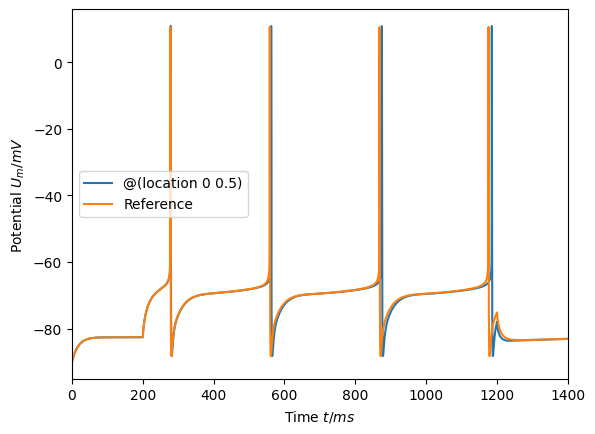

In [24]:
run_allen_model(A.cable_cell(mrf, dec, lbl, cvp), ref)

This gives us a good-enough match. There are some internal differences in the numerical methods used by Arbor and NEURON,
as well as how the NMODL definitions used in the Allen DB look like.

## Summary

We have seen how an externally defined model was imported into Arbor and used that to explore some
new concepts:
- Physical parameters
- Mechanism parameters
- Ion settings, reversal potential, and Nernst
- Discretisation policies

Not all models need to be transformed by hand, those defined in NeuroML2 and SONATA can be translated
automatically.

# Scanning Stimuli

In [47]:
def run_allen_model(ic, ax):
    tfinal = 1400
    dt = 0.005
    dec = A.decor()

    # set the default
    dec.set_property(
        tempK=default.temp,
        Vm=default.Vm,
        cm=default.cm,
        rL=default.rL,
    )
    # override regional parameters
    for region, vs in param.items():
        dec.paint(
            f'"{region}"',
            tempK=vs.temp,
            Vm=vs.Vm,
            cm=vs.cm,
            rL=vs.rL,
        )
    dec.set_ion("ca", int_con=5e-5*U.mM, ext_con=2.0*U.mM, method="nernst/x=ca")

    erev = dict()
    for kv in fit["conditions"][0]["erev"]:
        region = kv["section"]
        for k, v in kv.items():
            if k == "section":
                continue
            ion = k[1:]
            erev[(region, ion)] = float(v)*U.mV

    for (region, mech), values in mechs.items():
        nm = mech
        vs = {}
        sp = "/"
        for k, v in values.items():
            if mech == "pas" and k == "e":
                nm = f"{nm}{sp}{k}={v}"
                sp = ","
            else:
                vs[k] = v
        dec.paint(f'"{region}"', A.density(A.mechanism(nm, vs)))

    for (region, ion), e in erev.items():
        dec.paint(f'"{region}"', ion=ion, rev_pot=e)

    # Add current clamp
    # TODO: this should be parametrised
    dec.place('(location 0 0.5)', A.iclamp(200*U.ms, 1000*U.ms, ic*U.pA), "ic")
    # To detect spikes
    dec.place('(location 0 0.5)', A.threshold_detector(-10*U.mV), "dt")

    class recipe(A.recipe):

        def __init__(self):
            A.recipe.__init__(self)
            self.the_cell = A.cable_cell(mrf, dec, lbl, cvp)
            self.the_prop = A.neuron_cable_properties()
            self.the_prop.catalogue.extend(A.allen_catalogue(),'')

        def num_cells(self):
            return 1

        def cell_kind(self, gid):
            return A.cell_kind.cable

        def cell_description(self, gid):
            return self.the_cell

        def global_properties(self, kind):
            return self.the_prop

        def probes(self, gid):
            return [A.cable_probe_membrane_voltage('(location 0 0.5)', 'Um')]
            
    rec = recipe()
    sim = A.simulation(rec)
    hdl = sim.sample((0, 'Um'), A.regular_schedule(5*U.us))
    sim.record(A.spike_recording.all)
    sim.run(tfinal=tfinal*U.ms, dt=dt*U.ms)
    n_spike = len(sim.spikes())
    for data, meta in sim.samples(hdl):
        ax.plot(data[:, 0], data[:, 1], label=f"$I_c={ic}$ #spikes={n_spike}")
    ax.legend()
    ax.set_xlabel('Time $t/ms$')
    ax.set_ylabel('Potential $U_m/mV$')
    ax.set_xlim(0, tfinal)

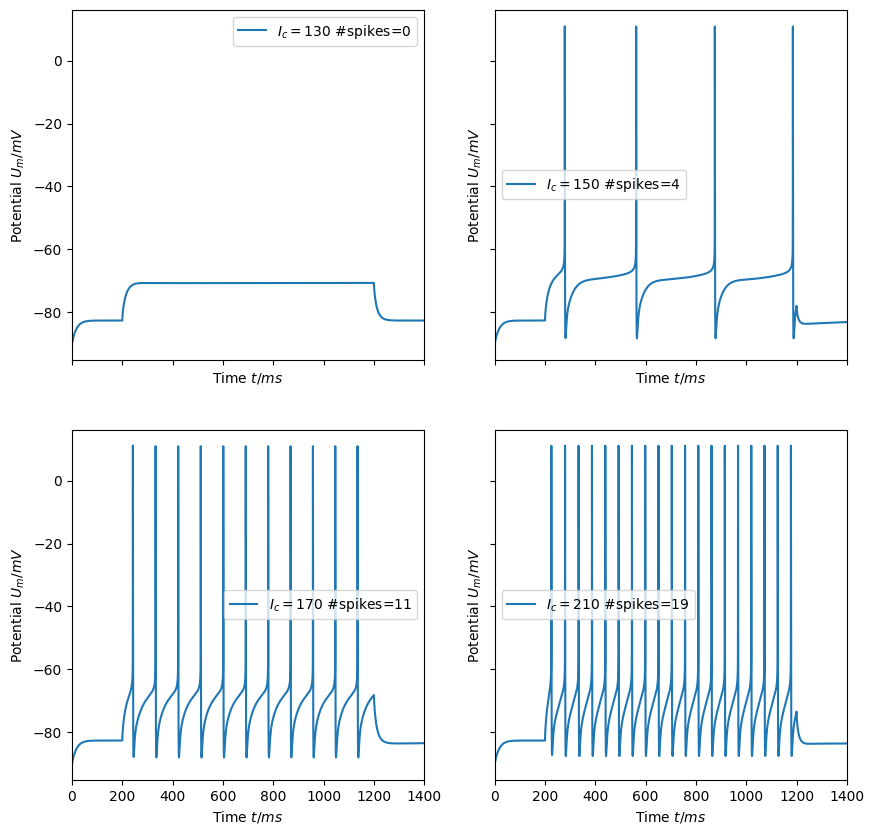

In [48]:
currents = [130, 150, 170, 210]

fg, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))

for ax, current in zip(axs.flatten(), currents):
    run_allen_model(current, ax)